# Optimizing Kaggle kernels using Intel(R) Extension for Scikit-learn*

For classical machine learning algorithms, we often use the most popular Python library, [scikit-learn](https://scikit-learn.org/stable/). We use it to fit models and search for optimal parameters, but scikit-learn sometimes works for hours, if not days. Speeding up this process is something anyone who uses scikit-learn would be interested in.

I want to show you how to get results faster without changing the code. To do this, we will use another Python library,  **[scikit-learn-intelex](https://github.com/intel/scikit-learn-intelex)**. It accelerates scikit-learn and does not require you changing the code written for scikit-learn.

I will use a Kaggle [notebook](https://www.kaggle.com/shivamb/tf-idf-with-ovr-svm-what-s-cooking) in which the training of the Support Vector Machine model executed in over **30 minutes**. 

## Problem Statement: SVM script for multiclass classification 

*What's Cooking:* Tf-IDF with One-vs-Rest Support Vector Machine (SVM) Model

*Goal:* Use recipe ingredients to categorize the cuisine

*Input:* Text Data (Ingredients for a Cuisine)

*Output:* Single Class (Cuisine Class)

*Author:* [sban](https://www.kaggle.com/shivamb)

*Created date:* 26 June 2018

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import json
from timeit import default_timer as timer

In [ ]:
%%time

def read_dataset(path):
    return json.load(open(path)) 

train = read_dataset('../input/whats-cooking-kernels-only/train.json')
test = read_dataset('../input/whats-cooking-kernels-only/test.json')

def generate_text(data):
    text_data = [" ".join(doc['ingredients']).lower() for doc in data]
    return text_data 

train_text = generate_text(train)
test_text = generate_text(test)
target = [doc['cuisine'] for doc in train]

tfidf = TfidfVectorizer(binary=True)
def tfidf_features(txt, flag):
    if flag == "train":
        x = tfidf.fit_transform(txt)
    else:
        x = tfidf.transform(txt)
    x = x.astype('float32')
    return x 
X = tfidf_features(train_text, flag="train")
X_test = tfidf_features(test_text, flag="test")

# Label Encoding - Target 
lb = LabelEncoder()
y = lb.fit_transform(target)

Let's take the training and predict into a separate function:

In [ ]:
def train_predict():
    from sklearn.svm import SVC
    classifier = SVC(C=100, # penalty parameter
                     kernel='rbf', # kernel type, rbf working fine here
                     degree=3, # default value
                     gamma=1, # kernel coefficient
                     coef0=1, # change to 1 from default value of 0.0
                     shrinking=True, # using shrinking heuristics
                     tol=0.001, # stopping criterion tolerance 
                     probability=False, # no need to enable probability estimates
                     cache_size=200, # 200 MB cache size
                     class_weight=None, # all classes are treated equally 
                     verbose=False, # print the logs 
                     max_iter=-1, # no limit, let it run
                     random_state=0)
    model = OneVsRestClassifier(classifier, n_jobs=4)
    model.fit(X, y)
    y_test = model.predict(X_test)
    return lb.inverse_transform(y_test)

In [ ]:
%%time
y_pred_original = train_predict()

The training of the SVM model took almost **30 minutes**. Let's try to use scikit-learn-intelex. First, download it: 

In [ ]:
!pip install scikit-learn-intelex --progress-bar off >> /tmp/pip_sklearnex.log

To get optimizations, patch scikit-learn using Intel(R) Extension:

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

Let’s run the same code to train the SVM model: 

In [ ]:
%%time
y_pred_oprimized = train_predict()

This time, the training took a **little over two minutes**, which saved us almost **28 minutes** Let’s make sure that the quality has not changed:

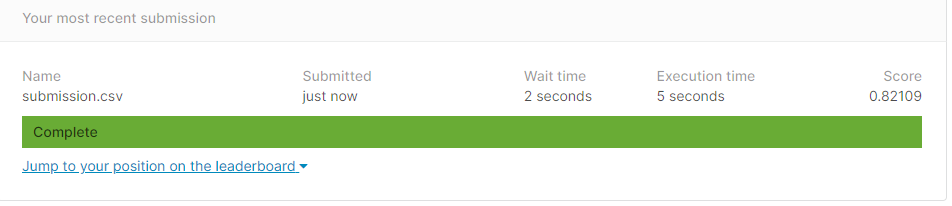

Save the result. Now the search for the perfect model has accelerated significantly.

In [ ]:
test_id = [doc['id'] for doc in test]
sub = pd.DataFrame({'id': test_id, 'cuisine': y_pred_oprimized}, columns=['id', 'cuisine'])
sub.to_csv('submission.csv', index=False)

With scikit-learn-intelex patching you can:

- Use your scikit-learn code for training and inference without modification.
- Train and predict scikit-learn models **up to 15 times faster**.
- Get the same quality of predictions as other tested frameworks.

*Please, upvote if you like.*